In [1]:
# make sure this is running in the right environment!! caiman, NOT caiman_test!
from IPython import get_ipython
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from scipy.ndimage import gaussian_filter
from tifffile.tifffile import imwrite,imread
from skimage import measure as sm

import largestinteriorrectangle as lir
import matplotlib.patches as pac
from copy import deepcopy

from scipy import interpolate as si
from scipy import signal as sg
from skimage import measure as sm
from skimage import transform as st
from scipy.sparse import csc_matrix

from tqdm.auto import tqdm,trange
%load_ext memory_profiler

from pathlib import Path
import pickle

import cv2
import multiprocessing
from joblib import Parallel, delayed
from joblib.externals.loky import get_reusable_executor

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d
from caiman.source_extraction.cnmf import cnmf,params
from caiman.utils.visualization import view_quilt,get_contours
from caiman.paths import caiman_datadir

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

import bokeh.plotting as bpl
bpl.output_notebook()

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.WARNING)

Loading BokehJS ...

In [2]:
#optimizing things from here - actually just stick with joblib/loky and take the L on timing - might not even be a CPU issue but data saving?
import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [5]:
chunkMeans = 6
n_cores = 10

data_dir_ds_l = [r'\\nasquatch\data\2p\peter\dipping\20230819_PL43\wells001\preprocessing\20230819_PL43_wells001',
                 r'\\nasquatch\data\2p\peter\dipping\20230819_PL43\wells101\preprocessing\20230819_PL43_wells101']
raw_path_l = [r'\\nasquatch\data\2p\peter\dipping\20230819_PL43\PL43_230819_001_full_wch0_aniso4_scale4AFS2PL4_toref34_wxy.npy',
             r'\\nasquatch\data\2p\peter\dipping\20230819_PL43\PL43_230819_101_full_wch0_aniso4_scale4AFS2PL4_toref31_wxy.npy']

zmt_l = [(3,27,52,0,None),(3,25,52,0,None)]

n_range_l = [None,None]

warp_ch0_l = [True,True]

In [15]:
chunkMeans = 6
n_cores = 10

data_dir_ds_l = [r'\\nasquatch\data\2p\peter\slice\20230801_SL2PL34\slice\preprocessing\20230801_SL2PL34_slice']
raw_path_l = [r'\\nasquatch\data\2p\peter\slice\20230801_SL2PL34\SL2PL34_230801_001_noartifact_wch0_aniso4_scale4.4AFS2PL4_toref27_wxy.npy']

zmt_l = [(3,27,52,0,None)]

n_range_l = [np.arange(5)]

warp_ch0_l = [False]

In [11]:
chunkMeans = 6
n_cores = 10

data_dir_ds_l = [r'\\NASQUATCH\data\2p\peter\slice\20230727_SL2PL32\slice\preprocessing\20230727_SL2PL32_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230727_SL2PL32\wells101\preprocessing\20230727_SL2PL32_wells101']
raw_path_l = [r'\\NASQUATCH\data\2p\peter\slice\20230727_SL2PL32\SL2PL32_230727_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref25_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230727_SL2PL32\PL32_230727_101_full_wch0_aniso4_scale4AFS2PL4_toref39_wxy.npy']

zmt_l = [(2,27,52,0,None),(8,23,52,0,71)]

n_range_l = [np.arange(5),None]

warp_ch0_l = [False,False]

In [7]:
chunkMeans = 6
n_cores = 10

data_dir_ds_l = [r'\\NASQUATCH\data\2p\peter\slice\20230616_SL1PL28\slice\preprocessing\20230616_SL1PL28_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230616_SL1PL28\wells001\preprocessing\20230616_SL1PL28_wells001',
                r'\\NASQUATCH\data\2p\peter\slice\20230824_SL1PL60\slice\preprocessing\20230824_SL1PL60_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230824_SL1PL60\wells001\preprocessing\20230824_SL1PL60_wells001',
                r'\\NASQUATCH\data\2p\peter\slice\20230824_SL1PL60\wells101\preprocessing\20230824_SL1PL60_wells101',
                r'\\NASQUATCH\data\2p\peter\dipping\20230823_PL28\wells001\preprocessing\20230823_PL28_wells001',
                r'\\NASQUATCH\data\2p\peter\dipping\20230823_PL28\wells101\preprocessing\20230823_PL28_wells101',
                r'\\NASQUATCH\data\2p\peter\dipping\20230823_PL28\wells201\preprocessing\20230823_PL28_wells201',
                r'\\NASQUATCH\data\2p\peter\dipping\20230925_PL58\wells001\preprocessing\20230925_PL58_wells001',
                r'\\NASQUATCH\data\2p\peter\dipping\20230925_PL58\wells101\preprocessing\20230925_PL58_wells101',
                r'\\NASQUATCH\data\2p\peter\dipping\20230925_PL58\wells201\preprocessing\20230925_PL58_wells201',
                r'\\NASQUATCH\data\2p\peter\dipping\20230925_PL58\wells301\preprocessing\20230925_PL58_wells301',
                r'\\NASQUATCH\data\2p\peter\dipping\20230925_PL58\wells401\preprocessing\20230925_PL58_wells401',
                r'\\NASQUATCH\data\2p\peter\dipping\20230926_PL56\wells001\preprocessing\20230926_PL56_wells001',
                r'\\NASQUATCH\data\2p\peter\dipping\20230926_PL56\wells101\preprocessing\20230926_PL56_wells101',
                r'\\NASQUATCH\data\2p\peter\dipping\20230926_PL56\wells201\preprocessing\20230926_PL56_wells201',
                r'\\NASQUATCH\data\2p\peter\dipping\20230926_PL56\wells301\preprocessing\20230926_PL56_wells301',
                r'\\NASQUATCH\data\2p\peter\dipping\20230926_PL56\wells401\preprocessing\20230926_PL56_wells401',
                r'\\NASQUATCH\data\2p\peter\dipping\20230926_PL56\wells501\preprocessing\20230926_PL56_wells501',
                r'\\NASQUATCH\data\2p\peter\dipping\20230927_PL34\wells001\preprocessing\20230927_PL34_wells001',
                r'\\NASQUATCH\data\2p\peter\dipping\20230927_PL34\wells101\preprocessing\20230927_PL34_wells101',
                r'\\NASQUATCH\data\2p\peter\dipping\20230927_PL34\wells201\preprocessing\20230927_PL34_wells201',
                r'\\NASQUATCH\data\2p\peter\dipping\20230927_PL34\wells301\preprocessing\20230927_PL34_wells301',
                r'\\NASQUATCH\data\2p\peter\dipping\20230927_PL58\wells001\preprocessing\20230927_PL58_wells001',
                r'\\NASQUATCH\data\2p\peter\dipping\20230927_PL58\wells101\preprocessing\20230927_PL58_wells101',
                r'\\NASQUATCH\data\2p\peter\dipping\20230927_PL58\wells201\preprocessing\20230927_PL58_wells201',
                r'\\NASQUATCH\data\2p\peter\dipping\20230927_PL58\wells301\preprocessing\20230927_PL58_wells301',
                r'\\NASQUATCH\data\2p\peter\in_vivo\220216_PK25PL8\mouse\preprocessing\220216_PK25PL8_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\220216_PK25PL8\wells101\preprocessing\220216_PK25PL8_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\220311_PK24PL9\mouse\preprocessing\220311_PK24PL9_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\220311_PK24PL9\wells101\preprocessing\220311_PK24PL9_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\220622_PK44PL17\mouse\preprocessing\220622_PK44PL17_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\220622_PK44PL17\wells101\preprocessing\220622_PK44PL17_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\220624_PK45PL13\mouse\preprocessing\220624_PK45PL13_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\220624_PK45PL13\wells101\preprocessing\220624_PK45PL13_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\220901_PK60PL36\mouse\preprocessing\220901_PK60PL36_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\220901_PK60PL36\wells101\preprocessing\220901_PK60PL36_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\220903_PK63PL34\mouse\preprocessing\220903_PK63PL34_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\220903_PK63PL34\wells101\preprocessing\220903_PK63PL34_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230615_DG69PL32\mouse\preprocessing\230615_DG69PL32_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230615_DG69PL32\wells101\preprocessing\230615_DG69PL32_wells101',
                r'\\NASQUATCH\data\2p\peter\slice\20230509_DA2PL55\slice\preprocessing\20230509_DA2PL55_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230511_DA1PL37\slice\preprocessing\20230511_DA1PL37_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230511_DA2PL45\slice\preprocessing\20230511_DA2PL45_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230607_SL2PL42\slice\preprocessing\20230607_SL2PL42_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230608_SL1PL37\slice\preprocessing\20230608_SL1PL37_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230608_SL2PL45\slice\preprocessing\20230608_SL2PL45_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230616_SL2PL39\slice\preprocessing\20230616_SL2PL39_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230727_SL1PL52\slice\preprocessing\20230727_SL1PL52_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230817_SL2PL60\slice\preprocessing\20230817_SL2PL60_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230822_SL1PL32\slice\preprocessing\20230822_SL1PL32_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230822_SL3PL58\slice\preprocessing\20230822_SL3PL58_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230824_SL2PL54\slice\preprocessing\20230824_SL2PL54_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230829_SL2PL39\slice\preprocessing\20230829_SL2PL39_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230829_SL3PL61\slice\preprocessing\20230829_SL3PL61_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230830_SL2PL60\slice\preprocessing\20230830_SL2PL60_slice']
raw_path_l = [r'\\NASQUATCH\data\2p\peter\slice\20230616_SL1PL28\SL1PL28_230616_001_wch0_aniso4_scale4.4AFS2PL4_toref18_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230616_SL1PL28\PL28_230616_001_full_wch0_aniso4_scale4.4AFS2PL4_toref11_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230824_SL1PL60\SL1PL60_230824_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref22_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230824_SL1PL60\PL60_230824_001_full_wch1_aniso4_scale4AFS2PL4_toref18_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230824_SL1PL60\PL60_230824_101_full_wch0_aniso4_scale4AFS2PL4_toref20_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230823_PL28\PL28_230823_001_full_wch0_aniso4_scale4AFS2PL4_toref18_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230823_PL28\PL28_230823_101_full_wch0_aniso4_scale4AFS2PL4_toref15_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230823_PL28\PL28_230823_201_full_wch0_aniso4_scale4AFS2PL4_toref46_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230925_PL58\PL58_230925_001_full_wch0_aniso4_scale4AFS2PL4_toref30_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230925_PL58\PL58_230925_101_full_wch0_aniso4_scale4AFS2PL4_toref15_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230925_PL58\PL58_230925_201_full_wch0_aniso4_scale4AFS2PL4_toref37_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230925_PL58\PL58_230925_301_full_wch0_aniso4_scale4AFS2PL4_toref31_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230925_PL58\PL58_230925_401_full_wch0_aniso4_scale4AFS2PL4_toref31_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230926_PL56\PL56_230926_001_full_wch0_aniso4_scale4AFS2PL4_toref25_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230926_PL56\PL56_230926_101_full_wch0_aniso4_scale4AFS2PL4_toref25_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230926_PL56\PL56_230926_201_full_wch0_aniso4_scale4AFS2PL4_toref32_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230926_PL56\PL56_230926_301_full_wch0_aniso4_scale4AFS2PL4_toref35_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230926_PL56\PL56_230926_401_full_wch0_aniso4_scale4AFS2PL4_toref30_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230926_PL56\PL56_230926_501_full_wch0_aniso4_scale4AFS2PL4_toref31_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230927_PL34\PL34_230927_001_full_wch0_aniso4_scale4AFS2PL4_toref20_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230927_PL34\PL34_230927_101_full_wch0_aniso4_scale4AFS2PL4_toref35_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230927_PL34\PL34_230927_201_full_wch0_aniso4_scale4AFS2PL4_toref37_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230927_PL34\PL34_230927_301_full_wch0_aniso4_scale4AFS2PL4_toref30_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230927_PL58\PL58_230927_001_full_wch0_aniso4_scale4AFS2PL4_toref25_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230927_PL58\PL58_230927_101_full_wch0_aniso4_scale4AFS2PL4_toref31_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230927_PL58\PL58_230927_201_full_wch0_aniso4_scale4AFS2PL4_toref30_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230927_PL58\PL58_230927_301_full_wch0_aniso4_scale4AFS2PL4_toref30_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\220216_PK25PL8\PK25PL8_220216_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref62_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\220216_PK25PL8\PK25PL8_220216_101_full_wch0_aniso4_scale4AFS2PL4_toref45_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\220311_PK24PL9\PK24PL9_220311_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref62_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\220311_PK24PL9\PK24PL9_220311_101_full_wch0_aniso4_scale4AFS2PL4_toref100_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\220622_PK44PL17\PK44PL17_220622_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref76_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\220622_PK44PL17\PK44PL17_220622_101_full_wch0_aniso4_scale4AFS2PL4_toref115_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\220624_PK45PL13\PK45PL13_220624_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref70_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\220624_PK45PL13\PK45PL13_220624_101_full_wch0_aniso4_scale4AFS2PL4_toref1_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\220901_PK60PL36\PK60PL36_220901_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref67_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\220901_PK60PL36\PK60PL36_220901_101_full_wch0_aniso4_scale4AFS2PL4_toref60_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\220903_PK63PL34\PK63PL34_220903_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref55_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\220903_PK63PL34\PK63PL34_220903_101_full_wch0_aniso4_scale4AFS2PL4_toref115_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230615_DG69PL32\DG69PL32_230615_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref71_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230615_DG69PL32\DG69PL32_230615_101_full_wch0_aniso4_scale4AFS2PL4_toref54_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230509_DA2PL55\DA2PL55_230509_001_wch0_aniso4_scale4AFS2PL4_toref16_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230511_DA1PL37\xx0DA1PL37_230511_001_wch0_aniso4_scale4AFS2PL4_toref15_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230511_DA2PL45\xx0DA2PL45_230511_001_wch0_aniso4_scale4AFS2PL4_toref18_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230607_SL2PL42\SL2PL42_230607_001_noartifact_wch0_aniso4_scale4.4AFS2PL4_toref25_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230608_SL1PL37\SL1PL37_230608_001_noartifact_wch0_aniso4_scale4.4AFS2PL4_toref18_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230608_SL2PL45\SL2PL45_230608_001_noartifact_wch0_aniso4_scale4.4AFS2PL4_toref26_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230616_SL2PL39\SL2PL39_230616_001_wch0_aniso4_scale4.4AFS2PL4_toref18_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230727_SL1PL52\SL1PL52_230727_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref18_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230817_SL2PL60\SL2PL60_230817_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref27_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230822_SL1PL32\SL1PL32_230822_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref28_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230822_SL3PL58\SL3PL58_230822_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref28_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230824_SL2PL54\SL2PL54_230824_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref33_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230829_SL2PL39\SL2PL39_230829_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref28_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230829_SL3PL61\SL3PL61_230829_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref28_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230830_SL2PL60\SL2PL60_230830_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref28_wxy.npy']

zmt_l = [(1,28,52,0,None),(3,27,52,0,23),
        (3,25,52,0,None),(3,26,52,0,None),(2,26,52,0,None),
        (2,26,52,0,None),(2,26,52,0,None),(5,25,52,0,89),
        (2,27,31,0,None),(3,25,31,0,None),(5,27,31,0,None),(2,27,31,0,None),(2,27,31,0,None),
        (2,26,31,0,None),(3,27,31,0,None),(3,26,31,0,None),(3,27,31,0,None),(2,26,31,0,None),(3,27,31,0,None),
        (2,27,31,0,None),(3,27,31,0,None),(3,26,31,0,None),(3,27,31,0,None),
        (3,26,31,0,None),(3,27,31,0,None),(4,27,31,0,None),(4,27,31,0,None),
        (2,27,52,0,None),(3,27,52,33,75),
        (2,26,52,10,None),(5,25,52,0,120),
        (4,26,52,5,None),(3,26,52,0,165),
        (3,27,52,0,None),(1,26,52,0,15),
        (2,25,52,0,None),(9,27,52,0,None),
        (2,26,52,6,None),(3,25,52,0,156),
        (2,27,52,0,None),(3,27,52,0,None),
        (1,17,52,0,None),
        (3,27,52,0,None),
        (2,26,52,0,None),
        (2,26,52,0,None),
        (2,27,52,0,None),
        (8,27,52,0,None),
        (2,25,52,0,40),
        (2,26,52,0,None),
        (3,27,52,0,None),
        (2,26,52,0,None),
        (2,25,52,0,45),
        (2,27,52,0,None),
        (2,27,52,0,None),
        (2,27,52,0,None),
        (2,26,52,0,42)]

n_range_l = [np.arange(5),None,
            np.arange(5),None,None,
            None,None,None,
            None,None,None,None,None,
            None,None,None,None,None,None,
            None,None,None,None,
            None,None,None,None,
            np.arange(30),None,
            np.arange(20),None,
            np.arange(20),None,
            np.arange(20),None,
            np.arange(30),None,
            np.arange(5),None,
            np.arange(10),None,
            np.arange(4),
            np.arange(4),
            np.arange(5),
            np.arange(4),
            np.arange(3),
            np.arange(3),
            np.arange(5),
            np.arange(3),
            np.arange(5),
            np.arange(5),
            np.arange(5),
            np.arange(5),
            np.arange(5),
            np.arange(5),
            np.arange(5)]

warp_ch0_l = [False,False,
             True,False,True,
             True,True,True,
             True,True,True,True,True,
             True,True,True,True,True,True,
             True,True,True,True,
             True,True,True,True,
             False,False,
             False,False,
             False,False,
             False,False,
             False,False,
             False,False,
             False,False,
             False,
             False,
             False,
             False,
             False,
             False,
             False,
             False,
             False,
             False,
             True,
             False,
             True,
             False,
             True]

In [3]:
chunkMeans = 6
n_cores = 10

data_dir_ds_l = [r'\\NASQUATCH\data\2p\peter\slice\20230831_SL1PL55\slice\preprocessing\20230831_SL1PL55_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230831_SL1PL55\wells001\preprocessing\20230831_SL1PL55_wells001',
                r'\\NASQUATCH\data\2p\peter\slice\20230830_SL1PL28\wells001\preprocessing\20230830_SL1PL28_wells001',
                r'\\NASQUATCH\data\2p\peter\slice\20230822_SL2PL52\slice\preprocessing\20230822_SL2PL52_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230822_SL2PL52\wells001\preprocessing\20230822_SL2PL52_wells001',
                r'\\NASQUATCH\data\2p\peter\slice\20230817_SL1PL55\slice\preprocessing\20230817_SL1PL55_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230817_SL1PL55\wells001\preprocessing\20230817_SL1PL55_wells001',
                r'\\NASQUATCH\data\2p\peter\slice\20230817_SL1PL55\wells101\preprocessing\20230817_SL1PL55_wells101',
                r'\\NASQUATCH\data\2p\peter\slice\20230801_SL1PL35\slice\preprocessing\20230801_SL1PL35_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230801_SL1PL35\wells101\preprocessing\20230801_SL1PL35_wells101',
                r'\\NASQUATCH\data\2p\peter\slice\20230607_SL1PL47\slice\preprocessing\20230607_SL1PL47_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230607_SL1PL47\wells001\preprocessing\20230607_SL1PL47_wells001',
                r'\\NASQUATCH\data\2p\peter\slice\20230606_SL1PL35\slice\preprocessing\20230606_SL1PL35_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230606_SL1PL35\washes\preprocessing\20230606_SL1PL35_washes',
                r'\\NASQUATCH\data\2p\peter\slice\20230509_DA1PL53\slice\preprocessing\20230509_DA1PL53_slice',
                r'\\NASQUATCH\data\2p\peter\slice\20230509_DA1PL53\wells101\preprocessing\20230509_DA1PL53_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\231030_DG60PL67\mouse\preprocessing\231030_DG60PL67_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\231025_DG56PL62\mouse\preprocessing\231025_DG56PL62_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\231024_DG54PL61\mouse\preprocessing\231024_DG54PL61_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\231018_DG52PL66\mouse\preprocessing\231018_DG52PL66_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\231018_DG52PL66\wells101\preprocessing\231018_DG52PL66_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230906_PS57PL56\mouse\preprocessing\230906_PS57PL56_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230905_PS56PL58\mouse\preprocessing\230905_PS56PL58_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230905_PS56PL58\wells101\preprocessing\230905_PS56PL58_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230902_DG90PL61\mouse\preprocessing\230902_DG90PL61_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230902_DG90PL61\wells101\preprocessing\230902_DG90PL61_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230810_DG87PL55\mouse\preprocessing\230810_DG87PL55_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230810_DG87PL55\wells101\preprocessing\230810_DG87PL55_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230807_DG84PL52\mouse\preprocessing\230807_DG84PL52_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230807_DG84PL52\wells101\preprocessing\230807_DG84PL52_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230802_DG48PL58\mouse\preprocessing\230802_DG48PL58_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230802_DG48PL58\wells101\preprocessing\230802_DG48PL58_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230726_DG47PL54\mouse\preprocessing\230726_DG47PL54_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230726_DG47PL54\wells101\preprocessing\230726_DG47PL54_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230720_PK97PL48\mouse\preprocessing\230720_PK97PL48_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230720_PK97PL48\wells101\preprocessing\230720_PK97PL48_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230617_DG70PL54\mouse\preprocessing\230617_DG70PL54_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230617_DG70PL54\wells101\preprocessing\230617_DG70PL54_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230526_PK84PL50\mouse\preprocessing\230526_PK84PL50_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230526_PK84PL50\wells101\preprocessing\230526_PK84PL50_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230525_DG42PL39\mouse\preprocessing\230525_DG42PL39_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230525_DG42PL39\wells101\preprocessing\230525_DG42PL39_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230519_DG41PL52\mouse\preprocessing\230519_DG41PL52_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\230519_DG41PL52\wells101\preprocessing\230519_DG41PL52_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\221018_PS10PL24\mouse\preprocessing\221018_PS10PL24_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\221018_PS10PL24\wells101\preprocessing\221018_PS10PL24_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\220427_PK27PL20\mouse\preprocessing\220427_PK27PL20_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\220427_PK27PL20\wells101\preprocessing\220427_PK27PL20_wells101',
                r'\\NASQUATCH\data\2p\peter\in_vivo\220406_PK24PL10\mouse\preprocessing\220406_PK24PL10_mouse',
                r'\\NASQUATCH\data\2p\peter\in_vivo\220406_PK24PL10\wells101\preprocessing\220406_PK24PL10_wells101',
                r'\\NASQUATCH\data\2p\peter\dipping\20230923_PL35\wells001\preprocessing\20230923_PL35_wells001',
                r'\\NASQUATCH\data\2p\peter\dipping\20230923_PL35\wells101\preprocessing\20230923_PL35_wells101',
                r'\\NASQUATCH\data\2p\peter\dipping\20230923_PL35\wells201\preprocessing\20230923_PL35_wells201',
                r'\\NASQUATCH\data\2p\peter\dipping\20230923_PL35\wells301\preprocessing\20230923_PL35_wells301',
                r'\\NASQUATCH\data\2p\peter\dipping\20230923_PL35\wells401\preprocessing\20230923_PL35_wells401',
                r'\\NASQUATCH\data\2p\peter\dipping\20230923_PL35\wells501\preprocessing\20230923_PL35_wells501',
                r'\\NASQUATCH\data\2p\peter\dipping\20230922_PL28\wells101\preprocessing\20230922_PL28_wells101',
                r'\\NASQUATCH\data\2p\peter\dipping\20230922_PL28\wells301\preprocessing\20230922_PL28_wells301',
                r'\\NASQUATCH\data\2p\peter\dipping\20230922_PL28\wells501\preprocessing\20230922_PL28_wells501',
                r'\\NASQUATCH\data\2p\peter\dipping\20230922_PL28\wells601\preprocessing\20230922_PL28_wells601',
                r'\\NASQUATCH\data\2p\peter\dipping\20230922_PL28\wells701\preprocessing\20230922_PL28_wells701',
                r'\\NASQUATCH\data\2p\peter\dipping\20230920_PL58\wells001\preprocessing\20230920_PL58_wells001',
                r'\\NASQUATCH\data\2p\peter\dipping\20230920_PL58\wells101\preprocessing\20230920_PL58_wells101',
                r'\\NASQUATCH\data\2p\peter\dipping\20230920_PL58\wells201\preprocessing\20230920_PL58_wells201',
                r'\\NASQUATCH\data\2p\peter\dipping\20230920_PL58\wells301\preprocessing\20230920_PL58_wells301',
                r'\\NASQUATCH\data\2p\peter\dipping\20230916_PL54\wells001\preprocessing\20230916_PL54_wells001',
                r'\\NASQUATCH\data\2p\peter\dipping\20230916_PL54\wells101\preprocessing\20230916_PL54_wells101',
                r'\\NASQUATCH\data\2p\peter\dipping\20230916_PL54\wells201\preprocessing\20230916_PL54_wells201',
                r'\\NASQUATCH\data\2p\peter\dipping\20230916_PL54\wells301\preprocessing\20230916_PL54_wells301',
                r'\\NASQUATCH\data\2p\peter\dipping\20230916_PL54\wells401\preprocessing\20230916_PL54_wells401',
                r'\\NASQUATCH\data\2p\peter\dipping\20230916_PL54\wells501\preprocessing\20230916_PL54_wells501',
                r'\\NASQUATCH\data\2p\peter\dipping\20230916_PL48\wells001\preprocessing\20230916_PL48_wells001',
                r'\\NASQUATCH\data\2p\peter\dipping\20230916_PL48\wells101\preprocessing\20230916_PL48_wells101',
                r'\\NASQUATCH\data\2p\peter\dipping\20230915_PL52\wells001\preprocessing\20230915_PL52_wells001',
                r'\\NASQUATCH\data\2p\peter\dipping\20230915_PL52\wells101\preprocessing\20230915_PL52_wells101',
                r'\\NASQUATCH\data\2p\peter\dipping\20230915_PL52\wells201\preprocessing\20230915_PL52_wells201',
                r'\\NASQUATCH\data\2p\peter\dipping\20230915_PL52\wells301\preprocessing\20230915_PL52_wells301',
                r'\\NASQUATCH\data\2p\peter\dipping\20230915_PL52\wells401\preprocessing\20230915_PL52_wells401']
raw_path_l = [r'\\NASQUATCH\data\2p\peter\slice\20230831_SL1PL55\SL1PL55_230831_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref28_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230831_SL1PL55\PL55_230831_001_full_wch0_aniso4_scale4AFS2PL4_toref52_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230830_SL1PL28\PL28_230830_001_full_wch0_aniso4_scale4AFS2PL4_toref52_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230822_SL2PL52\SL2PL52_230822_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref28_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230822_SL2PL52\PL52_230822_001_full_wch0_aniso4_scale4AFS2PL4_toref52_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230817_SL1PL55\SL1PL55_230817_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref27_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230817_SL1PL55\PL55_230817_001_full_wch0_aniso4_scale4AFS2PL4_toref18_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230817_SL1PL55\PL55_230817_101_full_wch0_aniso4_scale4AFS2PL4_toref39_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230801_SL1PL35\SL1PL35_230801_001_noartifact_wch0_aniso4_scale4.4AFS2PL4_toref27_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230801_SL1PL35\PL35_230801_101_full_wch0_aniso4_scale4AFS2PL4_toref76_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230607_SL1PL47\SL1PL47_230607_001_wch0_aniso4_scale4.4AFS2PL4_toref15_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230607_SL1PL47\PL47_230607_001_full_wch0_aniso4_scale4.4AFS2PL4_toref27_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230606_SL1PL35\SL1PL35_230606_001_wch0_aniso4_scale4.4AFS2PL4_toref18_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230606_SL1PL35\PL35_230606_001_wch0_aniso4_scale4.4AFS2PL4_toref9_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230509_DA1PL53\DA1PL53_230509_001_wch0_aniso4_scale4AFS2PL4_toref10_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\slice\20230509_DA1PL53\PL53_230509_101_full_wch0_aniso4_scale4.4AFS2PL4_toref8_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\231030_DG60PL67\DG60PL67_231030_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref49_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\231025_DG56PL62\DG56PL62_231025_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref85_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\231024_DG54PL61\DG54PL61_231024_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref71_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\231018_DG52PL66\DG52PL66_231018_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref71_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\231018_DG52PL66\DG52PL66_231018_101_full_wch0_aniso4_scale4AFS2PL4_toref34_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230906_PS57PL56\PS57PL56_230906_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref60_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230905_PS56PL58\PS56PL58_230905_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref89_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230905_PS56PL58\PS56PL58_230905_101_full_wch0_aniso4_scale4AFS2PL4_toref34_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230902_DG90PL61\DG90PL61_230902_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref75_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230902_DG90PL61\DG90PL61_230902_101_full_wch0_aniso4_scale4AFS2PL4_toref38_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230810_DG87PL55\DG87PL55_230810_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref94_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230810_DG87PL55\DG87PL55_230810_101_full_wch0_aniso4_scale4AFS2PL4_toref48_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230807_DG84PL52\DG84PL52_230807_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref73_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230807_DG84PL52\DG84PL52_230807_101_full_wch0_aniso4_scale4AFS2PL4_toref48_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230802_DG48PL58\DG48PL58_230802_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref71_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230802_DG48PL58\DG48PL58_230802_101_full_wch0_aniso4_scale4AFS2PL4_toref57_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230726_DG47PL54\DG47PL54_230726_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref71_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230726_DG47PL54\DG47PL54_230726_101_full_wch0_aniso4_scale4AFS2PL4_toref30_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230720_PK97PL48\PK97PL48_230720_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref70_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230720_PK97PL48\PK97PL48_230720_101_full_wch0_aniso4_scale4AFS2PL4_toref50_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230617_DG70PL54\DG70PL54_230617_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref71_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230617_DG70PL54\DG70PL54_230617_101_full_wch0_aniso4_scale4AFS2PL4_toref40_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230526_PK84PL50\PK84PL50_230526_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref62_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230526_PK84PL50\PL50_230526_101_full_wch0_aniso4_scale4AFS2PL4_toref1_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230525_DG42PL39\DG42PL39_230525_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref70_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230525_DG42PL39\PL39_230525_101_full_wch0_aniso4_scale4AFS2PL4_toref1_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230519_DG41PL52\DG41PL52_230519_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref71_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\230519_DG41PL52\PL52_230519_101_full_wch0_aniso4_scale4AFS2PL4_toref1_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\221018_PS10PL24\PS10PL24_221018_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref31_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\221018_PS10PL24\PS10PL24_221018_101_full_wch0_aniso4_scale4AFS2PL4_toref20_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\220427_PK27PL20\PK27PL20_220427_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref77_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\220427_PK27PL20\PK27PL20_220427_101_full_wch0_aniso4_scale4AFS2PL4_toref80_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\220406_PK24PL10\PK24PL10_220406_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref40_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\in_vivo\220406_PK24PL10\PK24PL10_220406_101_full_wch0_aniso4_scale4AFS2PL4_toref57_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230923_PL35\PL35_230923_001_full_wch0_aniso4_scale4AFS2PL4_toref25_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230923_PL35\PL35_230923_101_full_wch0_aniso4_scale4AFS2PL4_toref37_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230923_PL35\PL35_230923_201_full_wch0_aniso4_scale4AFS2PL4_toref37_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230923_PL35\PL35_230923_301_full_wch0_aniso4_scale4AFS2PL4_toref26_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230923_PL35\PL35_230923_401_full_wch0_aniso4_scale4AFS2PL4_toref36_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230923_PL35\PL35_230923_501_full_wch0_aniso4_scale4AFS2PL4_toref31_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230922_PL28\PL28_230922_101_full_wch0_aniso4_scale4AFS2PL4_toref15_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230922_PL28\PL28_230922_301_full_wch0_aniso4_scale4AFS2PL4_toref35_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230922_PL28\PL28_230922_501_full_wch0_aniso4_scale4AFS2PL4_toref15_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230922_PL28\PL28_230922_601_full_wch0_aniso4_scale4AFS2PL4_toref15_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230922_PL28\PL28_230922_701_full_wch0_aniso4_scale4AFS2PL4_toref40_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230920_PL58\PL58_230920_001_full_wch0_aniso4_scale4AFS2PL4_toref25_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230920_PL58\PL58_230920_101_full_wch0_aniso4_scale4AFS2PL4_toref15_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230920_PL58\PL58_230920_201_full_wch0_aniso4_scale4AFS2PL4_toref20_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230920_PL58\PL58_230920_301_full_wch0_aniso4_scale4AFS2PL4_toref40_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230916_PL54\PL54_230916_001_full_wch0_aniso4_scale4AFS2PL4_toref18_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230916_PL54\PL54_230916_101_full_wch0_aniso4_scale4AFS2PL4_toref13_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230916_PL54\PL54_230916_201_full_wch0_aniso4_scale4AFS2PL4_toref25_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230916_PL54\PL54_230916_301_full_wch0_aniso4_scale4AFS2PL4_toref19_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230916_PL54\PL54_230916_401_full_wch0_aniso4_scale4AFS2PL4_toref15_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230916_PL54\PL54_230916_501_full_wch0_aniso4_scale4AFS2PL4_toref35_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230916_PL48\PL48_230916_001_full_wch0_aniso4_scale4AFS2PL4_toref25_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230916_PL48\PL48_230916_101_full_wch0_aniso4_scale4AFS2PL4_toref40_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230915_PL52\PL52_230915_001_full_wch0_aniso4_scale4AFS2PL4_toref18_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230915_PL52\PL52_230915_101_full_wch0_aniso4_scale4AFS2PL4_toref15_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230915_PL52\PL52_230915_201_full_wch0_aniso4_scale4AFS2PL4_toref31_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230915_PL52\PL52_230915_301_full_wch0_aniso4_scale4AFS2PL4_toref25_wxy.npy',
             r'\\NASQUATCH\data\2p\peter\dipping\20230915_PL52\PL52_230915_401_full_wch0_aniso4_scale4AFS2PL4_toref19_wxy.npy']

zmt_l = [(1,27,52,0,None),(6,23,52,0,None),
        (3,25,52,0,None),
        (1,27,52,0,None),(3,27,52,0,81),
        (3,27,52,0,None),(3,27,52,0,None),(3,24,52,0,None),
        (2,27,52,0,None),(4,27,52,0,None),
        (3,26,52,0,None),(5,26,52,0,None),
        (4,27,52,0,None),(3,27,52,0,None),
        (2,27,52,0,None),(2,25,52,0,None),
        (3,27,52,10,80),
        (6,26,52,20,None),
        (4,27,52,0,130),
        (4,26,52,0,None),(5,27,52,0,None),
        (3,27,52,0,None),
        (3,27,52,0,155),(2,26,52,0,None),
        (3,27,52,10,None),(3,27,52,0,None),
        (3,26,52,0,None),(4,27,52,0,None),
        (2,26,52,0,None),(5,27,52,0,None),
        (4,27,52,0,None),(5,26,52,0,None),
        (4,27,52,0,None),(3,23,52,0,45),
        (4,26,52,0,None),(5,27,52,0,None),
        (3,27,52,0,None),(2,26,52,0,75),
        (3,24,52,0,None),(11,27,52,0,24),
        (4,23,52,0,None),(10,27,52,0,18),
        (3,26,52,5,None),(9,27,52,0,51),
        (2,26,52,0,62),(7,27,52,0,174),
        (2,25,52,10,None),(7,28,52,0,153),
        (3,26,52,10,None),(3,27,52,0,None),
        (2,26,31,0,None),(3,27,31,0,None),(2,27,31,0,None),(2,26,31,0,None),(2,26,31,0,None),(3,27,31,0,None),
        (3,27,31,0,None),(3,27,31,0,None),(2,27,31,0,None),(2,27,31,0,None),(2,26,31,0,None),
        (3,26,31,0,None),(3,26,31,0,None),(4,27,31,0,None),(3,26,31,0,None),
        (3,26,31,0,None),(3,25,31,0,None),(3,27,31,0,None),(2,27,31,0,None),(2,27,31,0,None),(3,27,31,0,None),
        (2,26,31,0,None),(3,27,31,0,None),
        (4,26,31,0,None),(2,27,31,0,None),(3,26,31,0,None),(2,27,31,0,None),(3,27,31,0,None)]

n_range_l = [np.arange(5),None,
            None,
            np.arange(5),None,
            np.arange(5),None,None,
            np.arange(5),None,
            np.arange(4),None,
            np.arange(5),np.arange(4),
            np.arange(4),None,
            np.arange(20),
            np.arange(10),
            np.arange(20,35),
            np.arange(30),None,
            np.arange(30),
            np.arange(30),None,
            np.arange(20),None,
            np.arange(30),None,
            np.arange(20),None,
            np.arange(30),None,
            np.arange(30),None,
            np.arange(30),None,
            np.arange(20),None,
            np.arange(20),None,
            np.arange(20),None,
            np.arange(20),None,
            np.arange(20),None,
            np.arange(10),None,
            np.arange(20),None,
            None,None,None,None,None,None,
            None,None,None,None,None,
            None,None,None,None,
            None,None,None,None,None,None,
            None,None,
            None,None,None,None,None]

warp_ch0_l = [False,True,
             True,
             False,True,
             False,False,False,
             False,False,
             False,False,
             False,False,
             False,False,
             True,
             True,
             True,
             True,True,
             True,
             True,True,
             True,True,
             False,False,
             False,False,
             False,False,
             False,False,
             False,False,
             False,False,
             False,False,
             False,False,
             False,False,
             False,False,
             False,False,
             False,False,
             True,True,True,True,True,True,
             True,True,True,True,True,
             True,True,True,True,
             True,True,True,True,True,True,
             True,True,
             True,True,True,True,True]

In [9]:
chunkMeans = 6
n_cores = 10

data_dir_ds_l = [r'\\nasquatch\data\2p\peter\dipping\20230922_PL28\wells001\preprocessing\20230922_PL28_wells001',
                r'\\nasquatch\data\2p\peter\dipping\20230922_PL28\wells201\preprocessing\20230922_PL28_wells201',
                r'\\nasquatch\data\2p\peter\dipping\20230922_PL28\wells401\preprocessing\20230922_PL28_wells401',
                r'\\nasquatch\data\2p\peter\dipping\20230922_PL28\wells601\preprocessing\20230922_PL28_wells601',
                r'\\nasquatch\data\2p\peter\slice\20230830_SL1PL28\slice\preprocessing\20230830_SL1PL28_slice',
                r'\\nasquatch\data\2p\peter\slice\20230830_SL1PL28\wells001\preprocessing\20230830_SL1PL28_wells001',
                r'\\nasquatch\data\2p\peter\slice\20230829_SL1PL56\slice\preprocessing\20230829_SL1PL56_slice',
                r'\\nasquatch\data\2p\peter\slice\20230829_SL1PL56\wells001\preprocessing\20230829_SL1PL56_wells001',
                r'\\nasquatch\data\2p\peter\slice\20230817_SL1PL55\slice\preprocessing\20230817_SL1PL55_slice',
                r'\\nasquatch\data\2p\peter\slice\20230817_SL1PL55\wells001\preprocessing\20230817_SL1PL55_wells001',
                r'\\nasquatch\data\2p\peter\slice\20230817_SL1PL55\wells101\preprocessing\20230817_SL1PL55_wells101',
                r'\\nasquatch\data\2p\peter\in_vivo\220408_PK27PL20\mouse\preprocessing\220408_PK27PL20_mouse',
                r'\\nasquatch\data\2p\peter\in_vivo\220408_PK27PL20\wells101\preprocessing\220408_PK27PL20_wells101',
                r'\\nasquatch\data\2p\peter\in_vivo\230707_DG72PL32\mouse\preprocessing\230707_DG72PL32_mouse',
                r'\\nasquatch\data\2p\peter\in_vivo\230707_DG72PL32\wells101\preprocessing\230707_DG72PL32_wells101',
                r'\\nasquatch\data\2p\peter\in_vivo\230902_DG90PL61\mouse\preprocessing\230902_DG90PL61_mouse',
                r'\\nasquatch\data\2p\peter\in_vivo\230906_PS57PL56\wells\preprocessing\230906_PS57PL56_wells',
                r'\\nasquatch\data\2p\peter\in_vivo\231024_DG54PL61\mouse\preprocessing\231024_DG54PL61_mouse',
                r'\\nasquatch\data\2p\peter\in_vivo\231030_DG60PL67\mouse\preprocessing\231030_DG60PL67_mouse',
                r'\\nasquatch\data\2p\peter\in_vivo\220701_PK49PL18\mouse\preprocessing\220701_PK49PL18_mouse',
                r'\\nasquatch\data\2p\peter\in_vivo\220701_PK49PL18\wells101\preprocessing\220701_PK49PL18_wells101']
raw_path_l = [r'\\nasquatch\data\2p\peter\dipping\20230922_PL28\PL28_230922_001_full_wch1_aniso4_scale4AFS2PL4_toref35_wxy.npy',
             r'\\nasquatch\data\2p\peter\dipping\20230922_PL28\PL28_230922_201_full_wch1_aniso4_scale4AFS2PL4_toref19_wxy.npy',
             r'\\nasquatch\data\2p\peter\dipping\20230922_PL28\PL28_230922_401_full_wch1_aniso4_scale4AFS2PL4_toref18_wxy.npy',
             r'\\nasquatch\data\2p\peter\dipping\20230922_PL28\PL28_230922_601_full_wch1_aniso4_scale4AFS2PL4_toref15_wxy.npy',
             r'\\nasquatch\data\2p\peter\slice\20230830_SL1PL28\SL1PL28_230830_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref28_wxy.npy',
             r'\\nasquatch\data\2p\peter\slice\20230830_SL1PL28\PL28_230830_001_full_wch1_aniso4_scale4AFS2PL4_toref52_wxy.npy',
             r'\\nasquatch\data\2p\peter\slice\20230829_SL1PL56\SL1PL56_230829_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref28_wxy.npy',
             r'\\nasquatch\data\2p\peter\slice\20230829_SL1PL56\PL56_230829_001_full_wch1_aniso4_scale4AFS2PL4_toref52_wxy.npy',
             r'\\nasquatch\data\2p\peter\slice\20230817_SL1PL55\SL1PL55_230817_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref27_wxy.npy',
             r'\\nasquatch\data\2p\peter\slice\20230817_SL1PL55\PL55_230817_001_full_wch1_aniso4_scale4AFS2PL4_toref18_wxy.npy',
             r'\\nasquatch\data\2p\peter\slice\20230817_SL1PL55\PL55_230817_101_full_wch1_aniso4_scale4AFS2PL4_toref39_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\220408_PK27PL20\PK27PL20_220408_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref71_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\220408_PK27PL20\PK27PL20_220408_101_full_wch0_aniso4_scale4AFS2PL4_toref57_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\230707_DG72PL32\DG72PL32_230707_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref40_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\230707_DG72PL32\DG72PL32_230707_101_full_wch0_aniso4_scale4AFS2PL4_toref35_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\230902_DG90PL61\DG90PL61_230902_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref75_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\230906_PS57PL56\PS57PL56_230906_101_full_wch1_aniso4_scale4AFS2PL4_toref34_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\231024_DG54PL61\DG54PL61_231024_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref71_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\231030_DG60PL67\DG60PL67_231030_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref49_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\220701_PK49PL18\PK49PL18_220701_001_noartifact_wch0_aniso4_scale4AFS2PL4_toref76_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\220701_PK49PL18\PK49PL18_220701_101_full_wch0_aniso4_scale4AFS2PL4_toref100_wxy.npy']

zmt_l = [(3,27,31,0,None),
        (2,27,31,0,None),
        (2,27,31,0,None),
        (2,27,31,0,None),
        (1,27,52,0,42),
        (3,25,52,0,None),
        (2,27,52,0,None),
        (5,23,52,0,None),
        (3,27,52,0,None),
        (3,27,52,0,None),
        (3,24,52,0,None),
        (3,26,52,5,None),
        (3,26,52,0,81),
        (2,27,52,10,None),
        (3,21,52,0,75),
        (3,27,52,10,160),
        (3,25,31,3,None),
        (5,26,52,0,120),
        (3,27,52,10,80),
        (2,26,52,60,None),
        (6,26,52,0,159)]

n_range_l = [None,
            None,
            None,
            None,
            np.arange(5),
            None,
            np.arange(5),
            None,
            np.arange(5),
            None,
            None,
            np.arange(10),
            None,
            np.arange(20),
            None,
            np.arange(20),
            None,
            np.arange(20,35),
            np.arange(20),
            np.arange(20),
            None]

In [6]:
chunkMeans = 6
n_cores = 10

data_dir_ds_l = [r'\\nasquatch\data\2p\peter\in_vivo\231108_DG61PL62\wells\preprocessing\231108_DG61PL62_wells',
                r'\\nasquatch\data\2p\peter\in_vivo\231107_DG44PL58\wells\preprocessing\231107_DG44PL58_wells',
                r'\\nasquatch\data\2p\peter\in_vivo\231106_DG52PL68\wells\preprocessing\231106_DG52PL68_wells',
                r'\\nasquatch\data\2p\peter\in_vivo\231105_DG39PL32\wells\preprocessing\231105_DG39PL32_wells',
                r'\\nasquatch\data\2p\peter\in_vivo\231031_DG53PL28\wells\preprocessing\231031_DG53PL28_wells',
                r'\\nasquatch\data\2p\peter\in_vivo\231030_DG60PL67\wells\preprocessing\231030_DG60PL67_wells',
                r'\\nasquatch\data\2p\peter\in_vivo\231025_DG56PL62\mouse\preprocessing\231025_DG56PL62_mouse',
                r'\\nasquatch\data\2p\peter\in_vivo\231025_DG56PL62\wells\preprocessing\231025_DG56PL62_wells',
                r'\\nasquatch\data\2p\peter\in_vivo\231024_DG54PL61\mouse\preprocessing\231024_DG54PL61_mouse',
                r'\\nasquatch\data\2p\peter\in_vivo\231024_DG54PL61\wells\preprocessing\231024_DG54PL61_wells']
raw_path_l = [r'\\nasquatch\data\2p\peter\in_vivo\231108_DG61PL62\DG61PL62_231108_101_full_wch1_aniso4_scale4AFS2PL4_toref34_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\231107_DG44PL58\DG44PL58_231107_101_full_wch1_aniso4_scale4AFS2PL4_toref34_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\231106_DG52PL68\DG52PL68_231106_101_full_wch1_aniso4_scale4AFS2PL4_toref34_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\231105_DG39PL32\DG39PL32_231105_201_full_wch1_aniso4_scale4AFS2PL4_toref34_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\231031_DG53PL28\DG53PL28_231031_101_full_wch1_aniso4_scale4AFS2PL4_toref34_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\231030_DG60PL67\DG60PL67_231030_101_full_wch1_aniso4_scale4AFS2PL4_toref34_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\231025_DG56PL62\DG56PL62_231025_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref85_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\231025_DG56PL62\DG56PL62_231025_101_full_wch1_aniso4_scale4AFS2PL4_toref34_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\231024_DG54PL61\DG54PL61_231024_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref71_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\231024_DG54PL61\DG54PL61_231024_101_full_wch1_aniso4_scale4AFS2PL4_toref34_wxy.npy']

zmt_l = [(8,24,52,0,None),
        (4,26,52,0,None),
        (3,24,52,0,None),
        (2,26,52,0,None),
        (2,26,52,0,None),
        (3,26,52,0,None),
        (5,25,52,15,None),
        (3,25,52,0,None),
        (5,26,52,0,None),
        (2,26,52,0,None)]

n_range_l = [None,
            None,
            None,
            None,
            None,
            None,
            np.arange(20),
            None,
            np.arange(15),
            None]

In [5]:
chunkMeans = 6
n_cores = 10

data_dir_ds_l = [#r'\\nasquatch\data\2p\peter\in_vivo\231018_DG52PL66\mouse\preprocessing\231018_DG52PL66_mouse',
                #r'\\nasquatch\data\2p\peter\in_vivo\231018_DG52PL66\wells\preprocessing\231018_DG52PL66_wells',
                #r'\\nasquatch\data\2p\peter\in_vivo\231017_DG49PL70\mouse\preprocessing\231017_DG49PL70_mouse',
                #r'\\nasquatch\data\2p\peter\in_vivo\230909_DG88PL58\mouse\preprocessing\230909_DG88PL58_mouse',
                r'\\nasquatch\data\2p\peter\in_vivo\230909_DG88PL58\wells\preprocessing\230909_DG88PL58_wells',
                r'\\nasquatch\data\2p\peter\in_vivo\230906_PS57PL56\mouse\preprocessing\230906_PS57PL56_mouse',
                r'\\nasquatch\data\2p\peter\in_vivo\230906_PS57PL56\wells\preprocessing\230906_PS57PL56_wells',
                r'\\nasquatch\data\2p\peter\in_vivo\230905_PS56PL58\mouse\preprocessing\230905_PS56PL58_mouse',
                r'\\nasquatch\data\2p\peter\in_vivo\230905_PS56PL58\wells\preprocessing\230905_PS56PL58_wells',
                r'\\nasquatch\data\2p\peter\in_vivo\230902_DG90PL61\mouse\preprocessing\230902_DG90PL61_mouse',
                r'\\nasquatch\data\2p\peter\in_vivo\230902_DG90PL61\wells\preprocessing\230902_DG90PL61_wells']
raw_path_l = [#r'\\nasquatch\data\2p\peter\in_vivo\231018_DG52PL66\DG52PL66_231018_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref71_wxy.npy',
             #r'\\nasquatch\data\2p\peter\in_vivo\231018_DG52PL66\DG52PL66_231018_101_full_wch1_aniso4_scale4AFS2PL4_toref34_wxy.npy',
             #r'\\nasquatch\data\2p\peter\in_vivo\231017_DG49PL70\DG49PL70_231017_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref71_wxy.npy',
             #r'\\nasquatch\data\2p\peter\in_vivo\230909_DG88PL58\DG88PL58_230909_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref71_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\230909_DG88PL58\DG88PL58_230909_101_full_wch1_aniso4_scale4AFS2PL4_toref34_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\230906_PS57PL56\PS57PL56_230906_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref60_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\230906_PS57PL56\PS57PL56_230906_101_full_wch1_aniso4_scale4AFS2PL4_toref34_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\230905_PS56PL58\PS56PL58_230905_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref89_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\230905_PS56PL58\PS56PL58_230905_101_full_wch1_aniso4_scale4AFS2PL4_toref34_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\230902_DG90PL61\DG90PL61_230902_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref75_wxy.npy',
             r'\\nasquatch\data\2p\peter\in_vivo\230902_DG90PL61\DG90PL61_230902_101_full_wch1_aniso4_scale4AFS2PL4_toref38_wxy.npy']

zmt_l = [#(6,26,52,0,None),
        #(4,27,52,0,None),
        #(3,27,52,0,None),
        #(5,27,52,10,None),
        (2,26,31,0,None),
        (4,27,52,0,None),
        (3,25,31,0,None),
        (5,27,52,0,155),
        (1,25,52,0,None),
        (5,27,52,0,None),
        (2,27,52,0,None)]

n_range_l = [#np.arange(30),
            #None,
            #np.arange(30),
            #np.arange(20),
            None,
            np.arange(30),
            None,
            np.arange(30),
            None,
            np.arange(30),
            None]

In [6]:
for m in trange(0,len(data_dir_ds_l)):
    data_dir_ds = data_dir_ds_l[m]
    raw_path = raw_path_l[m]
    z1 = zmt_l[m][0]
    z2 = zmt_l[m][1]
    mov_means = zmt_l[m][2]
    t1 = zmt_l[m][3]
    t2 = zmt_l[m][4]
    warp_ch0 = warp_ch0_l[m]
    
    data_dir_ds = data_dir_ds.replace(f'\\',f'/')
    raw_path = raw_path.replace(f'\\',f'/')

    n_range = n_range_l[m]

    data_dir = os.path.dirname(os.path.dirname(data_dir_ds))
    if warp_ch0:
        fnamex = data_dir+f'/segtrack/tiffs/ch0/'+str(mov_means)+f'_mean_warped_ch0/means_movie.npy'
    else:
        fnamex = data_dir+f'/segtrack/tiffs/ch0/'+str(mov_means)+f'_mean_warped_/means_movie.npy'
    Yx = np.load(fnamex,mmap_mode='r+')
    Yx = Yx.transpose([0,2,3,1])
    Yx = Yx[t1:t2,:,:,z1:z2]
    
    Yz = np.min(Yx,axis=0)
    Yz = np.array(Yz!=0,order='C')
    Yd = np.min(Yz,axis=2)
    vgrid2 = lir.lir(np.array(Yd,order='C'))
    vgrid2[2] = vgrid2[0]+vgrid2[2]
    vgrid2[3] = vgrid2[1]+vgrid2[3]
    Yxx = Yx[:,vgrid2[1]:vgrid2[3],vgrid2[0]:vgrid2[2],:]
    dims = Yxx.shape[1:]

    fnamef = raw_path
    Yf = np.load(fnamef,mmap_mode='r+')
    Yf = Yf.transpose([0,4,1,2,3])
    ch = 0

    t1m = t1*mov_means
    try:
        t2m = t2*mov_means
    except:
        t2m = None
    Yf = Yf[ch,t1m:t2m,vgrid2[1]:vgrid2[3],vgrid2[0]:vgrid2[2],z1:z2]

    fnamez = data_dir_ds+f'/ch0_means_movie_bg.tif'
    Yxy2bg = imread(fnamez)

    base_name='D://pkalugin/memmap_cache/' + os.path.split(fnamef)[1][:-4] + '_nobg/memmap_'
    T, dims = Yf.shape[0], Yf.shape[1:]
    order='C'
    fname_tot = cm.paths.generate_fname_tot(base_name, dims, order)
    save_path = Path(fname_tot).parent
    save_path.mkdir(parents=True,exist_ok=True)

    big_mov = np.memmap(fname_tot, 
                dtype=np.float32, 
                mode='w+', 
                shape=cm.mmapping.prepare_shape((np.prod(dims),T)), 
                order='C')
    del big_mov
    big_mov = np.memmap(fname_tot, 
                dtype=np.float32, 
                mode='r+', 
                shape=cm.mmapping.prepare_shape((np.prod(dims),T)), 
                order='C')

    def interp_loop(big_mov,i):
        #big_mov = np.memmap(fname_tot, 
        #            dtype=np.float32, 
        #            mode='r+', 
        #            shape=cm.mmapping.prepare_shape((np.prod(dims),T)), 
        #            order='C')
        if i==0:
            dbounds = [0,chunkMeans+1] # range of bg to load
            ebounds = [0,mov_means*chunkMeans] # range of upsampled bg to keep
            sbounds = [0,mov_means*chunkMeans] # range of Yf to load
        elif i==(Yxy2bg.shape[0]-1) - ((Yxy2bg.shape[0]-1) % chunkMeans):
            dbounds = [i-1,Yxy2bg.shape[0]]
            ebounds = [mov_means,(Yxy2bg.shape[0]-i+1)*mov_means]
            sbounds = [i*mov_means,Yf.shape[0]]
        else:
            dbounds = [i-1,i+chunkMeans+1]
            ebounds = [mov_means,(chunkMeans+1)*mov_means]
            sbounds = [i*mov_means,(i+chunkMeans)*mov_means]
        Ytemp = Yf[sbounds[0]:sbounds[1],...]
        Ybgtemp = st.rescale(Yxy2bg[dbounds[0]:dbounds[1],...],(mov_means,1,1,1),order=1,mode='edge',clip=False,preserve_range=True) # 5:17 min chunk 10, ~3:30 min chunk 5 (~11 GB)
        if ebounds[1]-ebounds[0] < Ytemp.shape[0]:
            Ybgtemp = np.concatenate((Ybgtemp,np.repeat(Ybgtemp[Ybgtemp.shape[0]-1,...][np.newaxis,:,:,:],Ytemp.shape[0]-ebounds[1]+ebounds[0],axis=0)),dtype=Ybgtemp.dtype)
            ebounds[1] = Ybgtemp.shape[0]
        Ttemp, dimstemp = Ytemp.shape[0], Ytemp.shape[1:]
        Ytempnobg = np.transpose((Ytemp - Ybgtemp[ebounds[0]:ebounds[1],...]),list(range(1, len(dimstemp) + 1)) + [0]) #~20 GB chunk 10? ~14 GB chunk 5 (peak)
        #Ytempnobg = np.transpose(np.multiply((Ytemp - Ybgtemp[ebounds[0]:ebounds[1],...]),bmaskz),list(range(1, len(dimstemp) + 1)) + [0]) #bmaskz doubles ram usage - unnecessary for refit
        del Ybgtemp
        Ytempnobg = Ytempnobg.reshape((np.prod(dimstemp),Ttemp),order='F')
        Ytempnobg = np.ascontiguousarray(Ytempnobg,dtype=np.float32) + np.float32(0.0001)
        big_mov[:,sbounds[0]:sbounds[1]] = Ytempnobg
        #del big_mov, Ytemp, Ytempnobg
        del Ytemp, Ytempnobg
    
    with tqdm_joblib(tqdm(desc="Subtracting background...", total=len(range(0,Yxy2bg.shape[0],chunkMeans)))) as progress_bar:
        Parallel(n_jobs=n_cores,batch_size=1,temp_folder="D:/pkalugin/temp")(delayed(interp_loop)(big_mov,i) for i in range(0,Yxy2bg.shape[0],chunkMeans))
    get_reusable_executor().shutdown(wait=True)
    del big_mov

    fname_new = cm.paths.fn_relocated(fname_tot + f'_frames_{cm.mmapping.prepare_shape((np.prod(dims),T))[1]}.mmap')
    os.rename(fname_tot, fname_new)

  0%|          | 0/2 [00:00<?, ?it/s]


Subtracting background...: 100%|████████████| 12/12 [1:21:15<00:00, 406.33s/it]

Subtracting background...: 100%|██████████████| 11/11 [19:07<00:00, 104.35s/it]


In [5]:
big_mov.shape

(3310750, 5460)

In [6]:
Yxx.shape

(105, 410, 475, 17)

In [8]:
Yf.shape

(5460, 410, 475, 17)

In [9]:
Yxy2bg.shape

(105, 411, 480, 17)

In [3]:
data_dir_ds = data_dir_ds.replace(f'\\',f'/')
raw_path = raw_path.replace(f'\\',f'/')

In [4]:
n_range = np.arange(30)
#n_range = None # use None for dipping since there's no baseline
print(n_range)
t1 = 0
#t1 = 15
t2 = None

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [5]:
data_dir = os.path.dirname(os.path.dirname(data_dir_ds))
print(data_dir)

//nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/mouse


In [6]:
# make directory here more universal - use it at the bottom to save everything
fnamex = data_dir+f'/segtrack/tiffs/ch0/'+str(mov_means)+f'_mean_warped_/means_movie.npy'
#z1 = 5
#z2 = 26
Yx = np.load(fnamex,mmap_mode='r+')
print(Yx.shape) # chTZYX
Yx = Yx.transpose([0,2,3,1])
Yx.shape #chTYXZ - keep it like this to get correct movie orientation at the end!
Yx = Yx[t1:t2,:,:,z1:z2]
Yx.shape #TYXZ

(169, 30, 450, 510)


(169, 450, 510, 21)

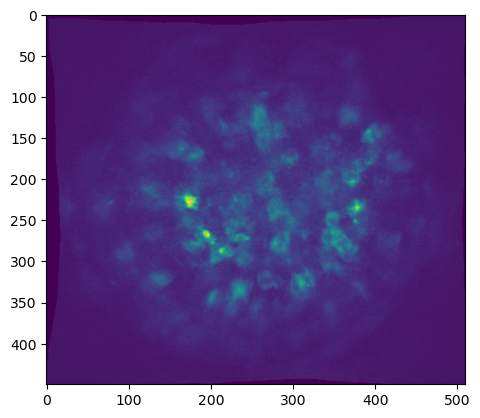

In [7]:
plt.imshow(Yx[0,:,:,10])

In [8]:
%%time
Yz = np.min(Yx,axis=0)
Yz = np.array(Yz!=0,order='C')
Yd = np.min(Yz,axis=2)
vgrid2 = lir.lir(np.array(Yd,order='C'))
vgrid2[2] = vgrid2[0]+vgrid2[2]
vgrid2[3] = vgrid2[1]+vgrid2[3]
Yxx = Yx[:,vgrid2[1]:vgrid2[3],vgrid2[0]:vgrid2[2],:]
dims = Yxx.shape[1:]
Yxx.shape

CPU times: total: 12.6 s
Wall time: 22 s


(169, 428, 486, 21)

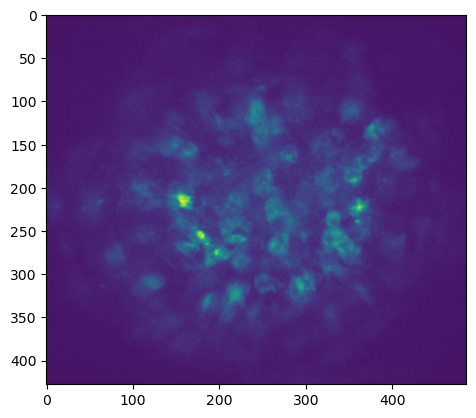

In [9]:
plt.imshow(Yxx[0,:,:,10])

In [10]:
fnamef = raw_path
Yf = np.load(fnamef,mmap_mode='r+')
print(Yf.shape) # chYXZT
Yf = Yf.transpose([0,4,1,2,3])
print(Yf.shape) #chTYXZ - keep it like this to get correct movie orientation at the end!
ch = 0
Yf = Yf[ch,t1:t2,vgrid2[1]:vgrid2[3],vgrid2[0]:vgrid2[2],z1:z2]
Yf.shape #TYXZ

(2, 450, 510, 30, 8819)
(2, 8819, 450, 510, 30)


(8819, 428, 486, 21)

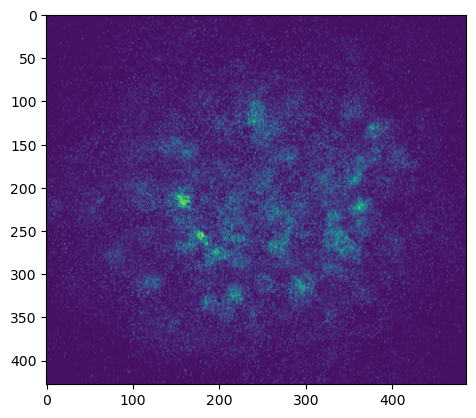

In [11]:
plt.imshow(Yf[0,:,:,10])

In [12]:
%%time
fnamez = data_dir_ds+f'/ch0_means_movie_bg.tif'
Yxy2bg = imread(fnamez)
print(Yxy2bg.shape)

(169, 428, 486, 21)
CPU times: total: 6.25 s
Wall time: 26.6 s


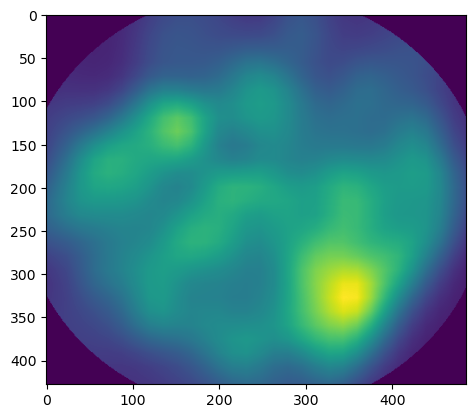

In [13]:
plt.imshow(Yxy2bg[100,:,:,10])

In [14]:
base_name='D://pkalugin/memmap_cache/' + os.path.split(fnamef)[1][:-4] + '_nobg/memmap_'
#base_name='//megatron/e/pkalugin/memmap_cache/' + os.path.split(fnamef)[1][:-4] + '_nobg/memmap_'
T, dims = Yf.shape[0], Yf.shape[1:]
order='C'
fname_tot = cm.paths.generate_fname_tot(base_name, dims, order)
print(fname_tot)
save_path = Path(fname_tot).parent
save_path.mkdir(parents=True,exist_ok=True)

D://pkalugin/memmap_cache/DG61PL62_231108_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref85_wxy_nobg/memmap_d1_428_d2_486_d3_21_order_C


In [16]:
#optimizing things from here - actually just stick with joblib/loky and take the L on timing - might not even be a CPU issue but data saving?
import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [17]:
%%time
## background subtraction and memory mapping (full movie)
# separate multicore from single core blocks for windows!
# starts with ~ 13 GB RAM total, ~10 GB in this process
chunkMeans = 6
n_cores = 15
big_mov = np.memmap(fname_tot, 
            dtype=np.float32, 
            mode='w+', 
            shape=cm.mmapping.prepare_shape((np.prod(dims),T)), 
            order='C')
del big_mov

CPU times: total: 31.2 ms
Wall time: 67 ms


In [ ]:
%%time
#for i in trange(0,Yxy2bg.shape[0],chunkMeans)
def interp_loop(i):
    big_mov = np.memmap(fname_tot, 
                dtype=np.float32, 
                mode='r+', 
                shape=cm.mmapping.prepare_shape((np.prod(dims),T)), 
                order='C')
    if i==0:
        dbounds = [0,chunkMeans+1] # range of bg to load
        ebounds = [0,mov_means*chunkMeans] # range of upsampled bg to keep
        sbounds = [0,mov_means*chunkMeans] # range of Yf to load
    elif i==(Yxy2bg.shape[0]-1) - ((Yxy2bg.shape[0]-1) % chunkMeans):
        dbounds = [i-1,Yxy2bg.shape[0]]
        ebounds = [mov_means,(Yxy2bg.shape[0]-i+1)*mov_means]
        sbounds = [i*mov_means,Yf.shape[0]]
    else:
        dbounds = [i-1,i+chunkMeans+1]
        ebounds = [mov_means,(chunkMeans+1)*mov_means]
        sbounds = [i*mov_means,(i+chunkMeans)*mov_means]
    Ytemp = Yf[sbounds[0]:sbounds[1],...]
    Ybgtemp = st.rescale(Yxy2bg[dbounds[0]:dbounds[1],...],(mov_means,1,1,1),order=1,mode='edge',clip=False,preserve_range=True) # 5:17 min chunk 10, ~3:30 min chunk 5 (~11 GB)
    if ebounds[1]-ebounds[0] < Ytemp.shape[0]:
        Ybgtemp = np.concatenate((Ybgtemp,np.repeat(Ybgtemp[Ybgtemp.shape[0]-1,...][np.newaxis,:,:,:],Ytemp.shape[0]-ebounds[1]+ebounds[0],axis=0)),dtype=Ybgtemp.dtype)
        ebounds[1] = Ybgtemp.shape[0]
    Ttemp, dimstemp = Ytemp.shape[0], Ytemp.shape[1:]
    Ytempnobg = np.transpose((Ytemp - Ybgtemp[ebounds[0]:ebounds[1],...]),list(range(1, len(dimstemp) + 1)) + [0]) #~20 GB chunk 10? ~14 GB chunk 5 (peak)
    #Ytempnobg = np.transpose(np.multiply((Ytemp - Ybgtemp[ebounds[0]:ebounds[1],...]),bmaskz),list(range(1, len(dimstemp) + 1)) + [0]) #bmaskz doubles ram usage - unnecessary for refit
    del Ybgtemp
    Ytempnobg = Ytempnobg.reshape((np.prod(dimstemp),Ttemp),order='F')
    Ytempnobg = np.ascontiguousarray(Ytempnobg,dtype=np.float32) + np.float32(0.0001)
    big_mov[:,sbounds[0]:sbounds[1]] = Ytempnobg
    del big_mov, Ytemp, Ytempnobg

with tqdm_joblib(tqdm(desc="Subtracting background...", total=len(range(0,Yxy2bg.shape[0],chunkMeans)))) as progress_bar:
    Parallel(n_jobs=n_cores,temp_folder="D:/pkalugin/temp")(delayed(interp_loop)(i) for i in range(0,Yxy2bg.shape[0],chunkMeans))

Subtracting background...:   0%|                        | 0/29 [00:00<?, ?it/s]

In [ ]:
fname_new = cm.paths.fn_relocated(fname_tot + f'_frames_{cm.mmapping.prepare_shape((np.prod(dims),T))[1]}.mmap')
os.rename(fname_tot, fname_new)
#del big_mov
    
Yr, dims, T = cm.load_memmap(fname_new)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 

In [ ]:
plt.imshow(images[0,:,:,10])

In [ ]:
%%time
# multiprocess pool version
from multiprocessing import Pool
import tqdm

## background subtraction and memory mapping (full movie)
# starts with ~ 13 GB RAM total, ~10 GB in this process
chunkMeans = 6
n_cores = 10
big_mov = np.memmap(fname_tot, 
            dtype=np.float32, 
            mode='w+', 
            shape=cm.mmapping.prepare_shape((np.prod(dims),T)), 
            order='C')
del big_mov
#for i in trange(0,Yxy2bg.shape[0],chunkMeans)
def interp_loop(i):
    big_mov = np.memmap(fname_tot, 
                dtype=np.float32, 
                mode='r+', 
                shape=cm.mmapping.prepare_shape((np.prod(dims),T)), 
                order='C')
    if i==0:
        dbounds = [0,chunkMeans+1] # range of bg to load
        ebounds = [0,mov_means*chunkMeans] # range of upsampled bg to keep
        sbounds = [0,mov_means*chunkMeans] # range of Yf to load
    elif i==(Yxy2bg.shape[0]-1) - ((Yxy2bg.shape[0]-1) % chunkMeans):
        dbounds = [i-1,Yxy2bg.shape[0]]
        ebounds = [mov_means,(Yxy2bg.shape[0]-i+1)*mov_means]
        sbounds = [i*mov_means,Yf.shape[0]]
    else:
        dbounds = [i-1,i+chunkMeans+1]
        ebounds = [mov_means,(chunkMeans+1)*mov_means]
        sbounds = [i*mov_means,(i+chunkMeans)*mov_means]
    Ytemp = Yf[sbounds[0]:sbounds[1],...]
    Ybgtemp = st.rescale(Yxy2bg[dbounds[0]:dbounds[1],...],(mov_means,1,1,1),order=1,mode='edge',clip=False,preserve_range=True) # 5:17 min chunk 10, ~3:30 min chunk 5 (~11 GB)
    if ebounds[1]-ebounds[0] < Ytemp.shape[0]:
        Ybgtemp = np.concatenate((Ybgtemp,np.repeat(Ybgtemp[Ybgtemp.shape[0]-1,...][np.newaxis,:,:,:],Ytemp.shape[0]-ebounds[1]+ebounds[0],axis=0)),dtype=Ybgtemp.dtype)
        ebounds[1] = Ybgtemp.shape[0]
    Ttemp, dimstemp = Ytemp.shape[0], Ytemp.shape[1:]
    Ytempnobg = np.transpose((Ytemp - Ybgtemp[ebounds[0]:ebounds[1],...]),list(range(1, len(dimstemp) + 1)) + [0]) #~20 GB chunk 10? ~14 GB chunk 5 (peak)
    #Ytempnobg = np.transpose(np.multiply((Ytemp - Ybgtemp[ebounds[0]:ebounds[1],...]),bmaskz),list(range(1, len(dimstemp) + 1)) + [0]) #bmaskz doubles ram usage - unnecessary for refit
    del Ybgtemp
    Ytempnobg = Ytempnobg.reshape((np.prod(dimstemp),Ttemp),order='F')
    Ytempnobg = np.ascontiguousarray(Ytempnobg,dtype=np.float32) + np.float32(0.0001)
    big_mov[:,sbounds[0]:sbounds[1]] = Ytempnobg
    del big_mov, Ytemp, Ytempnobg

if __name__ == '__main__':
    with Pool(processes = n_cores) as pool:
        for _ in tqdm.tqdm(pool.imap_unordered(interp_loop, range(0,Yxy2bg.shape[0],chunkMeans)), total=len(range(0,Yxy2bg.shape[0],chunkMeans))):
            pass

fname_new = cm.paths.fn_relocated(fname_tot + f'_frames_{cm.mmapping.prepare_shape((np.prod(dims),T))[1]}.mmap')
os.rename(fname_tot, fname_new)
#del big_mov
    
Yr, dims, T = cm.load_memmap(fname_new)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 

In [23]:
import joblib
print(joblib.__version__)

1.3.2


In [22]:
from joblib.externals.loky import get_reusable_executor
get_reusable_executor().shutdown(wait=True)

In [3]:
big_mov = np.memmap(fname_tot, 
                dtype=np.float32, 
                mode='r+', 
                shape=cm.mmapping.prepare_shape((np.prod(dims),T)), 
                order='C')

UnpicklingError: Failed to interpret file 'D://pkalugin/memmap_cache/DG44PL58_231107_001_noartifact_wch1_aniso4_scale4AFS2PL4_toref85_wxy_nobg/memmap_d1_438_d2_495_d3_23_order_C' as a pickle